# Conditional Generative Adversarial Network in TensorFlow

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

## Loading the data

As in previous examples, we'll use MNIST, because it's a small and easy-to-use dataset that comes bundled with Tensorflow.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Utility functions

The `variables_from_scope` function lists all variables created within a given scope. This will be useful later, when we want to update all "discriminator" variables, but no "generator" variables, or vice versa.

In [4]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

We'll also provide a simple function for displaying a few 28-pixel images. This will help us understand the progress of our GAN as it trains; we'll use it to visualize the generated 'fake digit' images.

In [5]:
def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    #print(images.dtype)
    images = images*255
    images = images.astype(np.int32)
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

## Hyperparameters

Let's now set some hyperparameters, for use later on.

In [6]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 100000
lr = 0.0004

## Generator

In [7]:
# Generator
def generator(x, y, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()
        cat1 = tf.concat([x, y], 1)
        hidden_layer = tf.layers.dense(cat1, intermediate_layer_size, kernel_initializer=w_init, activation=tf.nn.relu)
        fake_X = tf.layers.dense(hidden_layer, 784, kernel_initializer=w_init, activation=tf.nn.sigmoid)
        return fake_X


## Discriminator

In [8]:
# Discriminator

def discriminator(x, y, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()
        cat1 = tf.concat([x, y], 1)
        hidden_layer = tf.layers.dense(cat1, intermediate_layer_size, kernel_initializer=w_init, activation=tf.nn.relu)
        D_output = tf.layers.dense(hidden_layer, 1, kernel_initializer=w_init, activation=tf.nn.sigmoid)
        return D_output

## Building the graph

In [9]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
y = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, [None, z_dimension])


# networks : generator
fake_X = generator(z, y)

# networks : discriminator
D_real_logits = discriminator(real_X, y, )
D_fake_logits = discriminator(fake_X, y, reuse=True)

# Loss
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1])))
d_loss = D_loss_real + D_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1])))


# Optimizer & trainable variables
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_step = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(d_loss, var_list=D_vars)
    g_step = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(g_loss, var_list=G_vars)


# Initializer
initialize_all = tf.global_variables_initializer()



##  (a)(b)(c)  Build and train the Conditional GAN

Our training procedure is a bit more involved than in past demos. Here are the main differences:
1. Each iteration, we first train the generator, then (separately) the discriminator.
2. Each iteration, we need to feed in a batch of images, just as in previous notebooks. But we also need a batch of noise samples. For this, we use Numpy's `np.random.uniform` function.
3. Every 1000 iterations, we log some data to the console and visualize a few samples from our generator.

Iter [       0] Time [0.2984] d_loss [1.6285]


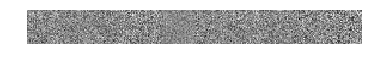

Iter [    1000] Time [2.3647] d_loss [1.0250]


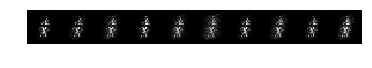

Iter [    2000] Time [4.1678] d_loss [1.0768]


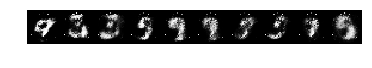

Iter [    3000] Time [5.9098] d_loss [1.0350]


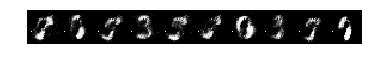

Iter [    4000] Time [7.5969] d_loss [1.0607]


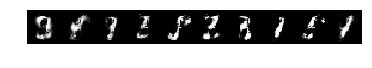

Iter [    5000] Time [9.2961] d_loss [1.0486]


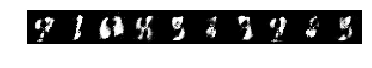

Iter [    6000] Time [10.9695] d_loss [1.0333]


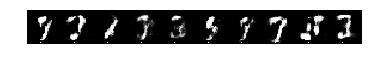

Iter [    7000] Time [12.7015] d_loss [1.0693]


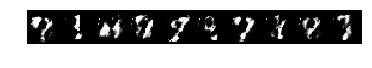

Iter [    8000] Time [14.3902] d_loss [1.0852]


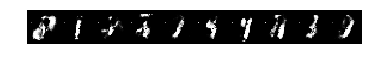

Iter [    9000] Time [16.0849] d_loss [1.0758]


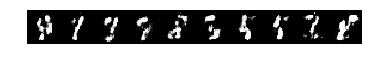

Iter [   10000] Time [17.7561] d_loss [1.0383]


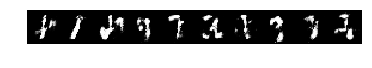

Iter [   11000] Time [19.4335] d_loss [1.0739]


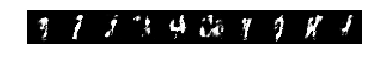

Iter [   12000] Time [21.0199] d_loss [1.0455]


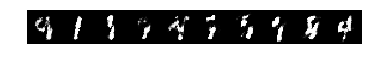

Iter [   13000] Time [22.7392] d_loss [1.0772]


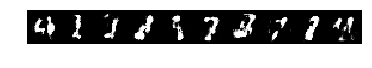

Iter [   14000] Time [24.6460] d_loss [1.0528]


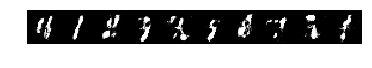

Iter [   15000] Time [26.3966] d_loss [1.0781]


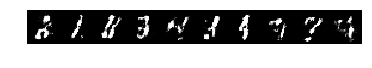

Iter [   16000] Time [28.2067] d_loss [1.0627]


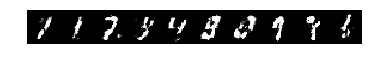

Iter [   17000] Time [29.9191] d_loss [1.0767]


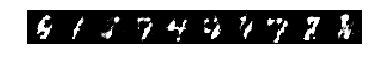

Iter [   18000] Time [31.6023] d_loss [1.0430]


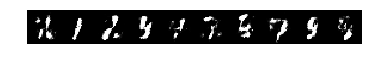

Iter [   19000] Time [33.3716] d_loss [1.0647]


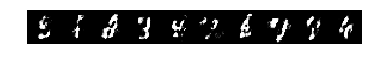

Iter [   20000] Time [35.1806] d_loss [1.0553]


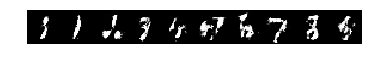

Iter [   21000] Time [37.2664] d_loss [1.0668]


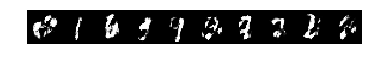

Iter [   22000] Time [38.9467] d_loss [1.0134]


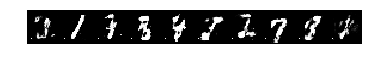

Iter [   23000] Time [40.5611] d_loss [1.0718]


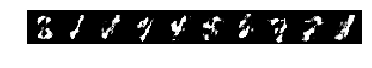

Iter [   24000] Time [42.2412] d_loss [1.0555]


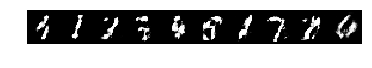

Iter [   25000] Time [43.9152] d_loss [1.0438]


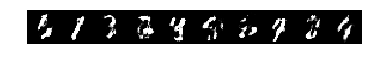

Iter [   26000] Time [45.9698] d_loss [1.0463]


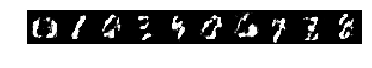

Iter [   27000] Time [48.1941] d_loss [1.0770]


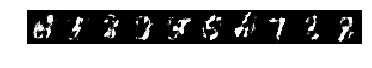

Iter [   28000] Time [50.0576] d_loss [1.1095]


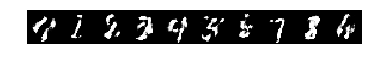

Iter [   29000] Time [51.7950] d_loss [1.0414]


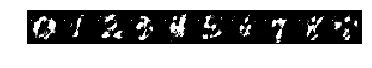

Iter [   30000] Time [53.5407] d_loss [1.0404]


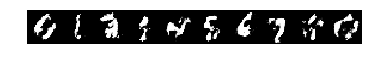

Iter [   31000] Time [55.2910] d_loss [1.0822]


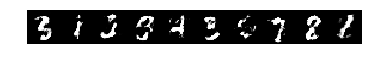

Iter [   32000] Time [57.1154] d_loss [1.0746]


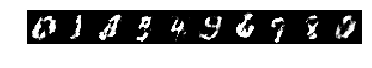

Iter [   33000] Time [58.8644] d_loss [1.0651]


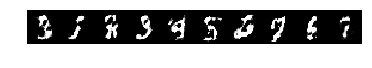

Iter [   34000] Time [60.6447] d_loss [1.0578]


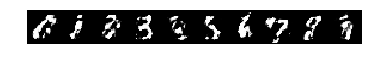

Iter [   35000] Time [62.4233] d_loss [1.1032]


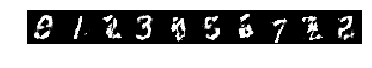

Iter [   36000] Time [64.1947] d_loss [1.0993]


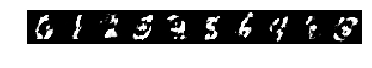

Iter [   37000] Time [65.8905] d_loss [1.1211]


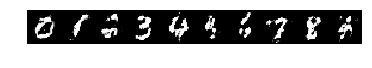

Iter [   38000] Time [67.6978] d_loss [1.0585]


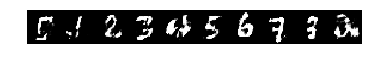

Iter [   39000] Time [69.3824] d_loss [1.0975]


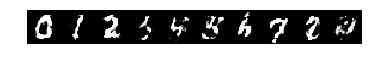

Iter [   40000] Time [71.1345] d_loss [1.1113]


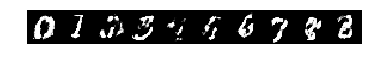

Iter [   41000] Time [72.8786] d_loss [1.1312]


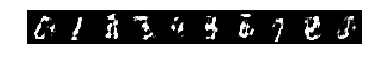

Iter [   42000] Time [74.6324] d_loss [1.0904]


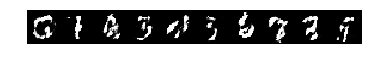

Iter [   43000] Time [76.3857] d_loss [1.0806]


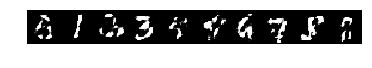

Iter [   44000] Time [78.1290] d_loss [1.6267]


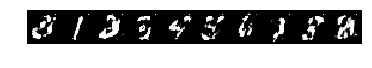

Iter [   45000] Time [79.7267] d_loss [1.6267]


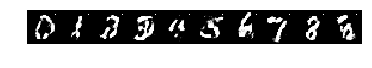

Iter [   46000] Time [81.3944] d_loss [1.6265]


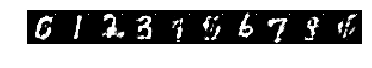

Iter [   47000] Time [83.1771] d_loss [1.0575]


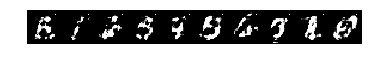

Iter [   48000] Time [84.8797] d_loss [1.3923]


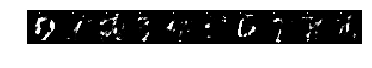

Iter [   49000] Time [86.6131] d_loss [1.0269]


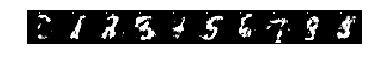

Iter [   50000] Time [88.2473] d_loss [1.0087]


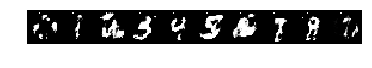

Iter [   51000] Time [90.0537] d_loss [1.0928]


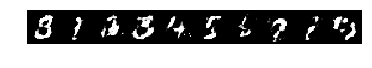

Iter [   52000] Time [91.8318] d_loss [1.3342]


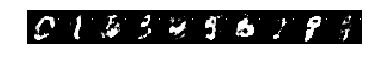

Iter [   53000] Time [93.5144] d_loss [1.1435]


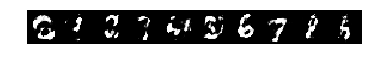

Iter [   54000] Time [95.2930] d_loss [1.0954]


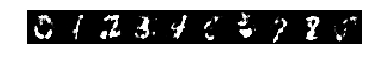

Iter [   55000] Time [96.9804] d_loss [1.1388]


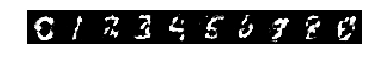

Iter [   56000] Time [98.7471] d_loss [1.1079]


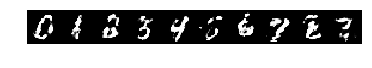

Iter [   57000] Time [100.4408] d_loss [1.0902]


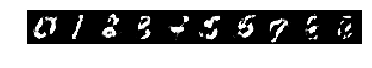

Iter [   58000] Time [102.1278] d_loss [1.1070]


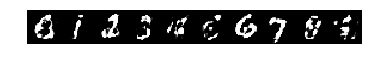

Iter [   59000] Time [103.9535] d_loss [1.6310]


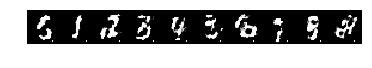

Iter [   60000] Time [105.6065] d_loss [1.0232]


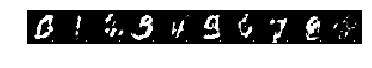

Iter [   61000] Time [107.2713] d_loss [1.0805]


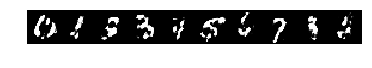

Iter [   62000] Time [108.9607] d_loss [1.1197]


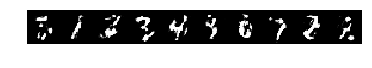

Iter [   63000] Time [110.7225] d_loss [1.1083]


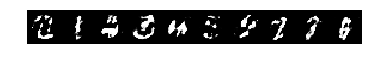

Iter [   64000] Time [112.6390] d_loss [1.0909]


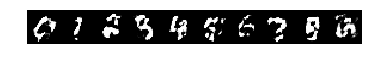

Iter [   65000] Time [114.3837] d_loss [1.6265]


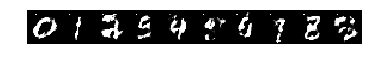

Iter [   66000] Time [116.0750] d_loss [1.6265]


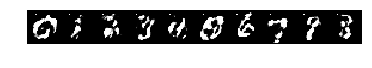

Iter [   67000] Time [117.7496] d_loss [1.6265]


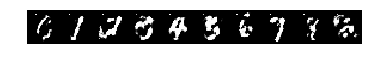

Iter [   68000] Time [119.4898] d_loss [1.6265]


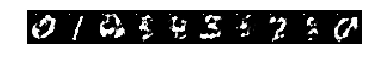

Iter [   69000] Time [121.2293] d_loss [1.6265]


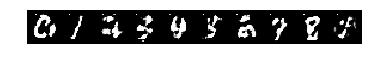

Iter [   70000] Time [123.0075] d_loss [1.6265]


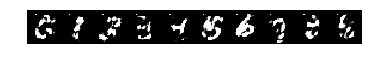

Iter [   71000] Time [124.7331] d_loss [1.6265]


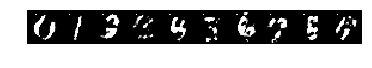

Iter [   72000] Time [126.3969] d_loss [1.6265]


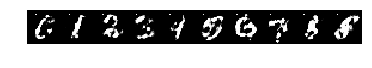

Iter [   73000] Time [128.1121] d_loss [1.6265]


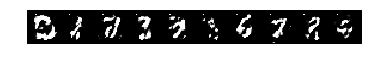

Iter [   74000] Time [129.8288] d_loss [1.6265]


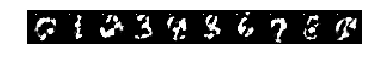

Iter [   75000] Time [131.5732] d_loss [1.6265]


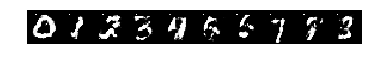

Iter [   76000] Time [133.3091] d_loss [1.6265]


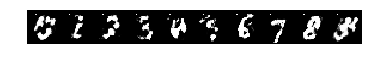

Iter [   77000] Time [135.0633] d_loss [1.6265]


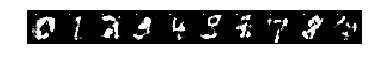

Iter [   78000] Time [136.6888] d_loss [1.6265]


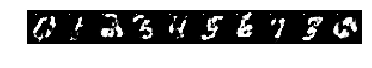

Iter [   79000] Time [138.6564] d_loss [1.6265]


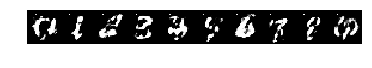

Iter [   80000] Time [140.6122] d_loss [1.6265]


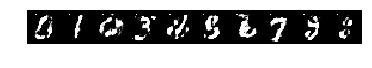

Iter [   81000] Time [142.4686] d_loss [1.6265]


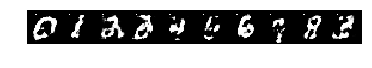

Iter [   82000] Time [144.1992] d_loss [1.6265]


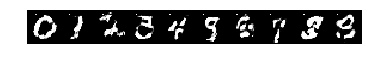

Iter [   83000] Time [145.9860] d_loss [1.6265]


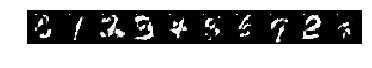

Iter [   84000] Time [147.6965] d_loss [1.6265]


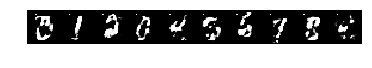

Iter [   85000] Time [149.4599] d_loss [1.6265]


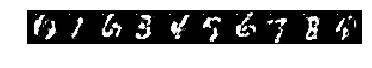

Iter [   86000] Time [151.2698] d_loss [1.6265]


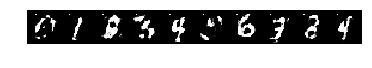

Iter [   87000] Time [153.1080] d_loss [1.6265]


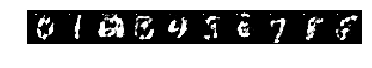

Iter [   88000] Time [154.7844] d_loss [1.6265]


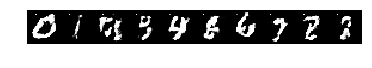

Iter [   89000] Time [156.5012] d_loss [1.6265]


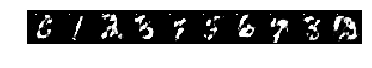

Iter [   90000] Time [158.2600] d_loss [1.6265]


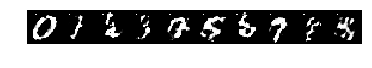

Iter [   91000] Time [160.0344] d_loss [1.6265]


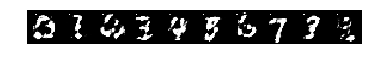

Iter [   92000] Time [161.7509] d_loss [1.6265]


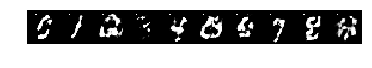

Iter [   93000] Time [163.4083] d_loss [1.6265]


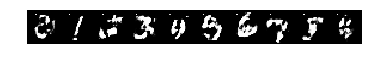

Iter [   94000] Time [165.1040] d_loss [1.6265]


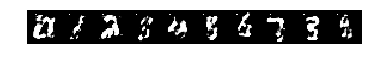

Iter [   95000] Time [166.8490] d_loss [1.6265]


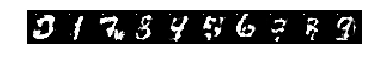

Iter [   96000] Time [168.6232] d_loss [1.6265]


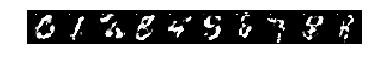

Iter [   97000] Time [170.5421] d_loss [1.6265]


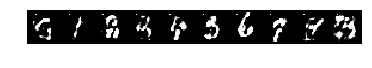

Iter [   98000] Time [172.3108] d_loss [1.6265]


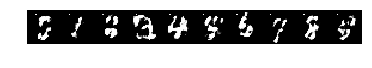

Iter [   99000] Time [174.1014] d_loss [1.6265]


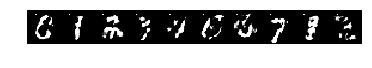

Iter [   99999] Time [175.7428] d_loss [1.6265]


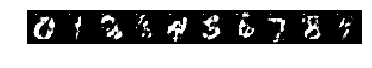

In [10]:
# Train the GAN.
def make_noise(batch_size):
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def D_next_feed_dict(batch_size):
    next_batch = mnist.train.next_batch(batch_size)
    return {real_X: next_batch[0],
            y:      next_batch[1],
            z:      make_noise(batch_size)}

def G_next_feed_dict(batch_size):
    next_batch = mnist.train.next_batch(batch_size)
    y_ = np.random.randint(0, 9, (batch_size, 1))
    onehot = np.eye(10)
    y_ = onehot[y_.astype(np.int32)].squeeze()
    return {real_X: next_batch[0],
            y:      y_,
            z:      make_noise(batch_size)}


sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    
    sess.run([g_step, g_loss], feed_dict=G_next_feed_dict(batch_size))
    _, loss = sess.run([d_step, d_loss], feed_dict=D_next_feed_dict(batch_size))
    
    if t % 1000 == 0 or t+1 == iterations:
        val_batch_size = 10
    
        fake_data = sess.run(fake_X, feed_dict={z: make_noise(val_batch_size), y:np.eye(10)})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

##  (d) Generate 10 images from each digit and visualize

0 :


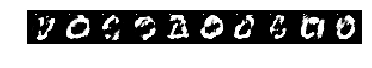

1 :


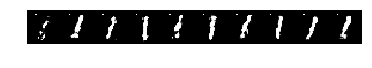

2 :


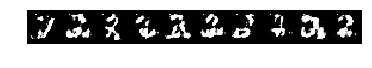

3 :


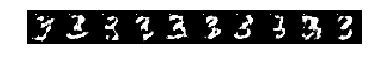

4 :


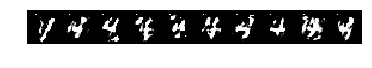

5 :


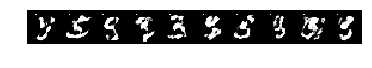

6 :


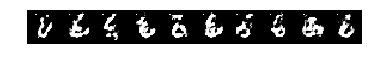

7 :


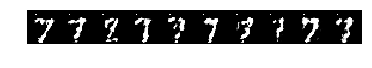

8 :


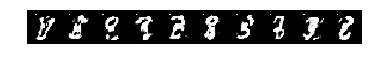

9 :


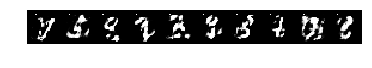

In [38]:
sample_batch_size = 10
sample_X = np.random.uniform(-1.0, 1.0, [sample_batch_size, z_dimension])
onehot = np.eye(10)

for i in range(10):
    y_ = np.tile(onehot[i],(10,1))
    generated = sess.run(fake_X, feed_dict={z: sample_X, y:y_})
    print(i,":")
    visualize_row(generated)